In [118]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor

import gini
from util_data import DataSet

In [119]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

In [120]:
def target_encode(trn_series=None,    # Revised to encode validation series
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):

    temp = pd.concat([trn_series, target], axis=1)
    
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    
    # Apply average function to all target data
    prior = target.mean()
    
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [121]:
correlated_features = ["ps_reg_03","ps_car_13"]
lacunar_features = ["ps_car_03_cat","ps_car_05_cat"]

In [122]:
data = DataSet()

train = data.get_training_set()
test = data.get_testing_set()

train = train.drop(correlated_features,axis=1).drop(lacunar_features,axis=1).drop(train.filter(like='calc').columns,axis=1)
test = test.drop(correlated_features,axis=1).drop(lacunar_features,axis=1).drop(test.filter(like='calc').columns,axis=1)

## Parametrization

In [123]:
categorical_features = train.filter(like='cat')+train.filter(like='bin')

X_train, X_test, Y_train, Y_test = train.drop(["id","target"],axis=1)[:500000],train.drop(["id","target"],axis=1)[-50000:],train.target[:500000],train.target[-50000:]

for f in categorical_features:
    X_train[f + "_avg"],X_test[f + "_avg"] = target_encode(
                                                        trn_series=X_train[f],
                                                        tst_series=X_test[f],
                                                        target=Y_train,
                                                        min_samples_leaf=200,
                                                        smoothing=10,
                                                        noise_level=0
                                                        )
    X_train.drop(f,axis=1)
    X_test.drop(f,axis=1)


X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

In [124]:
rfc = XGBClassifier(    
                        n_estimators=500,
                        max_depth=4,
                        objective="binary:logistic",
                        learning_rate=0.07, 
                        subsample=.8,
                        min_child_weight=6,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )
rfc.fit(X_train,Y_train)
Y_pred = rfc.predict_proba(X_test)

Gini: 0.131, Max. Gini: 0.482, Normalized Gini: 0.273


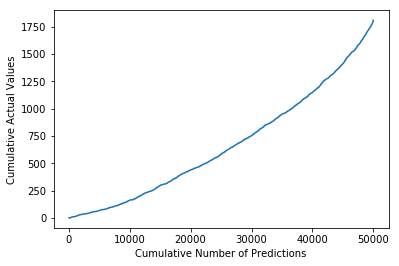

0.27250114126826025

In [125]:
gini.gini_visualization(Y_test,Y_pred[:,1],True)

## Test

In [112]:
categorical_features = train.filter(like='cat')+train.filter(like='bin')

X_train, X_test, Y_train = train.drop(["id","target"],axis=1),test.drop(["id"],axis=1),train.target

for f in categorical_features:
    X_train[f + "_avg"],X_test[f + "_avg"] = target_encode(
                                                        trn_series=X_train[f],
                                                        tst_series=X_test[f],
                                                        target=Y_train,
                                                        min_samples_leaf=200,
                                                        smoothing=10,
                                                        noise_level=0
                                                        )
    X_train.drop(f,axis=1)
    X_test.drop(f,axis=1)


X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

In [113]:
MAX_ROUNDS = 500
LEARNING_RATE = 0.07

rfc = XGBClassifier(    
                        n_estimators=MAX_ROUNDS,
                        max_depth=4,
                        objective="binary:logistic",
                        learning_rate=LEARNING_RATE, 
                        subsample=.8,
                        min_child_weight=6,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )
rfc.fit(X_train,Y_train)
Y_pred = rfc.predict_proba(X_test)

In [117]:
res = []
for i,p in zip(test.id, Y_pred[:,1]):
    res.append([i,max(0,p)])
    
pd.DataFrame(res,columns=["id","target"]).to_csv("prediction.csv",index = False)